In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs

mpl.rcParams['figure.figsize'] = 12, 8
mpl.rcParams['font.size'] = 18

### Regridding tutorial

Here I'm going to show the basics of regridding climate model output using xESMF, a python library that wraps the FORTRAN ESMF library, a powerful regridding toolset that is notoriously difficult to use. The python version makes everything very slick and user-friendly.

xESMF Documentation: https://pangeo-xesmf.readthedocs.io/en/latest/

### Loading the data to regrid

xESMF is designed to work with xarray Dataset objects. xarray is a python library for working with multidimensional data and making use of the metadata (e.g., dimension and coordinate names) contained in netCDF files. 

xarray documentation: http://xarray.pydata.org/en/stable/

An xarray Dataset is a nice representation of a netCDF file contents. If you print out the Dataset to the console, you get a nicely formatted view, with Dimensions, Coordinates, and Data variables listed separately, and how they relate to each other clearly laid out.

Accessing a single data variable from a Dataset (e.g., temperature) produces a DataArray object, which is similar but can only contain one variable.

In [21]:
ddir = '/glade/work/apauling/SOMoutput/'
dfile = 'SOMcontrol.cam.h0.TREFHT.0031-0060avg.nc'
ncf = ddir + dfile

# Open the netCDF file and display its contents as a Dataset object
ds = xr.open_dataset(ncf)
ds

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 1)
Coordinates:
  * time       (time) object 0046-01-15 10:00:00
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: nbnd
Data variables:
    time_bnds  (time, nbnd) object ...
    TREFHT     (time, lat, lon) float32 ...
Attributes: (12/13)
    Conventions:               CF-1.0
    source:                    CAM
    case:                      SOMcontrol
    title:                     UNSET
    logname:                   apauling
    host:                      r14i4n2
    ...                        ...
    revision_Id:               $Id$
    initial_file:              b.e12.B1850CN.f09_g16.002.cam.i.0145-01-01-000...
    topography_file:           /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/...
    history:                   Fri Nov 23 13:09:09 2018: ncra -d time,360,719...
    NCO:                       netCDF Operators version 4.7.4 (http://nco.sf....
    nco_openmp_thread_number:  1

### Loading the target grid

Here I will load the target grid, also as an xarray Dataset. In this example, I've used the CAM 2-degree grid information, taken from the CESM input data repository. It doesn't need to be a stand alone grid file though. If you have a netCDF file with data on the grid you want, just use that. xESMF will only use the grid information.

In [5]:
nco = 'fv_1.9x2.5.nc'
dso = xr.open_dataset(nco)
dso

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, slat: 95, slon: 144)
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * slat     (slat) float64 -89.05 -87.16 -85.26 -83.37 ... 85.26 87.16 89.05
  * slon     (slon) float64 -1.25 1.25 3.75 6.25 ... 348.8 351.2 353.8 356.2
Data variables:
    gw       (lat) float64 ...
    w_stag   (slat) float64 ...
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             f1.9o_1s
    title:            
    logname:          eaton
    host:             bs1201en
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /fs/cgd/csm/inputdata/atm/cam/inic/fv/cami_0000-09-01_1...
    topography_file:  /fs/cgd/csm/inputdata/atm/cam/topo/topo-from-cami_0000-...
    sst_file:         /fs/cgd/csm/inputdata/atm/cam/sst/sst_HadOIBl_bc_1.9x2....
    history:          Thu May 19 09:10:55 2005: ncks -v lat,lon,slat,slon,gw,...

### Create the Regridder object

Here is where we start using xESMF. The first step is to create a Regridder object, which is just a fancy container for the weights to translate from one grid to the other. You specify the input and output Datasets, the regridding method to use, and whether the data is periodic in longitude. 

If you specify a filename, as I've done here, xESMF will output the weights to a netCDF file. Then, by setting the option `reuse_weights=True`, when I run this again in the future, xESMF will just load the weights from that file, rather than recomputing them every time. For grids as coarse as I'm using here, this doesn't really matter, but for higher resolution generating the weights can take a while.

In [12]:
regridder = xe.Regridder(ds, dso,
                         method='bilinear',
                         periodic=True,
                         filename='bilinear_192x288_96x144_peri.nc',
                         reuse_weights=True)
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_192x288_96x144_peri.nc 
Reuse pre-computed weights? True 
Input grid shape:           (192, 288) 
Output grid shape:          (96, 144) 
Periodic in longitude?      True

### Access the temperature data

Here I access the temperature data from the Dataset we loaded earlier. This is now an xarray DataArray, containing the single variable TREFHT: the 2m air temperature from CAM.

In [14]:
t_native = ds['TREFHT'].squeeze()
t_native

<xarray.DataArray 'TREFHT' (lat: 192, lon: 288)>
array([[226.11842, 226.04054, 226.04749, ..., 226.0386 , 226.12674, 226.0653 ],
       [226.99219, 226.99133, 226.94565, ..., 226.88205, 227.11693, 227.06274],
       [228.12636, 228.04655, 227.96875, ..., 228.33257, 228.30121, 228.16458],
       ...,
       [251.12433, 251.13834, 251.15157, ..., 251.0869 , 251.09901, 251.1107 ],
       [251.04953, 251.055  , 251.06053, ..., 251.03175, 251.03775, 251.04376],
       [250.9476 , 250.94814, 250.94862, ..., 250.94565, 250.94637, 250.947  ]],
      dtype=float32)
Coordinates:
    time     object 0046-01-15 10:00:00
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

### Regrid to the target grid. 

Now that we have the Regridder and data created, regridding is as simple as giving the input data as an argument to the Regridder object. The output is another xarray DataArray, this time on the target grid.

In [15]:
t_regrid = regridder(t_native)
t_regrid

/glade/u/home/apauling/miniconda3/envs/xesmf_env/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


<xarray.DataArray 'TREFHT' (lat: 96, lon: 144)>
array([[226.11842346, 226.04748535, 226.02716064, ..., 226.06672668,
        226.12121582, 226.12861633],
       [228.13237893, 227.97235782, 227.85080779, ..., 228.63776624,
        228.44132722, 228.30924798],
       [228.50854284, 227.99004148, 227.56332484, ..., 230.43199019,
        229.74802956, 229.10318636],
       ...,
       [251.5084917 , 251.57393491, 251.63985804, ..., 251.31399507,
        251.38047363, 251.4458611 ],
       [251.12592347, 251.15333147, 251.17799691, ..., 251.04345756,
        251.07354244, 251.10045253],
       [250.94760132, 250.94760132, 250.94760132, ..., 250.94760132,
        250.94760132, 250.94760132]])
Coordinates:
    time     object 0046-01-15 10:00:00
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
Attributes:
    regrid_method:  bilinear

### Create a function for plotting

Since I'm making subplots, I made a short function to streamline the code to plot the output. I'm using the cartopy library to make maps. Cartopy is the standard python library for plotting on maps, having taken over from Basemap, which is being phased out. It works really nicely with xarray.

Cartopy documentation: https://scitools.org.uk/cartopy/docs/latest/

In [19]:
def plotstereo(fig, axnum, data, title):
    axs = fig.add_subplot(1, 2, axnum, projection=ccrs.SouthPolarStereo())
    axs.coastlines()
    axs.gridlines()
    axs.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
    im = data.plot.pcolormesh('lon', 'lat', ax=axs, transform=ccrs.PlateCarree())
    axs.set_title(title)
    im.set_clim(220, 280)
    
    return im, axs

### Plot the output

Here I've plotted the temperature data on the native and target grid. The agreement is very good, but we can clearly see the lower resolution of the target grid, indicating everything worked.

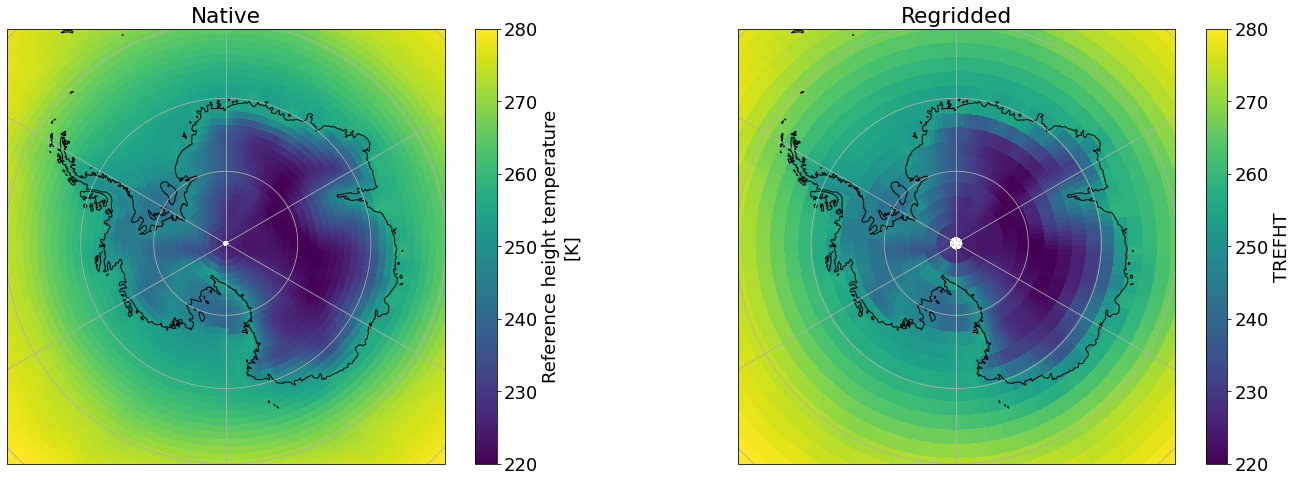

In [20]:
fig = plt.figure(figsize=(24, 8))
im1, ax1 = plotstereo(fig, 1, t_native, 'Native')
im2, ax2 = plotstereo(fig, 2, t_regrid, 'Regridded')